## Criando um modelo de classificacao pra definir a faixa etária de quem praticou o delito.

## 1- Importando a base de dados

In [1]:
#  Importando as bibliotecas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import date

 - Link do site onde encontra-se o dataset
 
 url:https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc

In [2]:
df=pd.read_csv('dataset.csv')

In [3]:
# visualizando as 5 primeiras linhas do dataset
df[0:5]

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,218375425,09/26/2020,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,M,1,0,25-44,M,WHITE,982285,201682,40.720255,-74.007090,POINT (-74.00709027999993 40.72025522300004)
1,217319714,09/02/2020,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",113.0,FORGERY,PL 1702500,F,M,5,0,18-24,F,BLACK,983903,200257,40.716344,-74.001253,POINT (-74.00125319299997 40.71634415200003)
2,218282529,09/24/2020,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN",107.0,BURGLARY,PL 1402000,F,M,34,0,45-64,M,BLACK,1003633,253391,40.862161,-73.929927,POINT (-73.92992712599995 40.862161439000026)
3,217526617,09/07/2020,792.0,WEAPONS POSSESSION 1 & 2,118.0,DANGEROUS WEAPONS,PL 2650303,F,K,67,0,18-24,M,BLACK,1003029,176696,40.651655,-73.932325,POINT (-73.93232493699998 40.65165467100008)
4,218518385,09/29/2020,268.0,CRIMINAL MIS 2 & 3,121.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450502,F,K,66,0,18-24,M,BLACK,988164,170927,40.635839,-73.985899,POINT (-73.98589935799998 40.635839049000026)


## 2- Preparaçao dos dados


 - Removendo as colunas que nao serão utilizadas 

In [4]:
dados=df.drop(['ARREST_KEY', 'PD_CD', 'PD_DESC', 'KY_CD', 'LAW_CODE','ARREST_PRECINCT', 'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD','New Georeferenced Column'], axis=1)

In [5]:
#  Renomeando as colunas

dados.columns = ['data_da_ocorrencia','descricao_da_ofensa','nivel_da_ofensa','bairro'
                     ,'idade_do_infrator','sexo_do_infrator','raca_do_infrator','latitude','longitude']

In [6]:
# reorganizando os dados referentes a data 

def date_to_weekday(date):
    weekday_dict = {0:'Monday', 1:'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    date_time_obj = datetime.datetime.strptime(date, '%m/%d/%Y')
    return weekday_dict[date_time_obj.weekday()]

date = dados['data_da_ocorrencia'].str.split("/", n = 3, expand = True)
dados['ano'] = date[2].astype('int32')
dados['dia'] = date[1].astype('int32')
dados['mes'] = date[0].astype('int32')
dados['dia_da_semana'] = dados['data_da_ocorrencia'].apply(date_to_weekday)

# alterando os dados da coluna nivel_da_ofensa

new_nivel_da_ofensa = {'M': "contravencao", 'F': "crime", 'V': "violacao",'I':"outro" }
dados['nivel_da_ofensa'] = dados['nivel_da_ofensa'].map(new_nivel_da_ofensa)

# alterando os dados da coluna bairro

new_bairro = {'B': 'Bronx', 'S': 'Staten_Island', 'K': 'Brooklyn', 'M': 'Manhattan' , 'Q': 'Queens' }
dados['bairro'] = dados['bairro'].map(new_bairro)

In [7]:
dados.head()

,data_da_ocorrencia,descricao_da_ofensa,nivel_da_ofensa,bairro,idade_do_infrator,sexo_do_infrator,raca_do_infrator,latitude,longitude,ano,dia,mes,dia_da_semana
0,09/26/2020,RAPE,crime,Manhattan,25-44,M,WHITE,40.720255,-74.007090,2020,26,9,Saturday
1,09/02/2020,FORGERY,crime,Manhattan,18-24,F,BLACK,40.716344,-74.001253,2020,2,9,Wednesday
2,09/24/2020,BURGLARY,crime,Manhattan,45-64,M,BLACK,40.862161,-73.929927,2020,24,9,Thursday
3,09/07/2020,DANGEROUS WEAPONS,crime,Brooklyn,18-24,M,BLACK,40.651655,-73.932325,2020,7,9,Monday
4,09/29/2020,CRIMINAL MISCHIEF & RELATED OF,crime,Brooklyn,18-24,M,BLACK,40.635839,-73.985899,2020,29,9,Tuesday


 - Convertendo a coluna " DATA_DA_OCORRENCIA "para formato datetime

In [8]:
dados["data_da_ocorrencia"] = pd.to_datetime(dados["data_da_ocorrencia"] )

## 3.1 Preparação dos Dados para modelagem
- Separação Treino/Teste
- Separar Dados de Entrada (Atributos) e de saída (target)
- Tratar colunas categóricas
- Tratar dados ausentes


## Criando um modelo de classificacao pra definir a faixa etária de quem praticou o delito.

 - Selecionando apenas os delitos mais recorrentes

In [9]:
# dados = dados.query('descricao_da_ofensa =="ASSAULT 3 & RELATED OFFENSES" or  descricao_da_ofensa =="FELONY ASSAULT" or descricao_da_ofensa =="PETIT LARCENY" or descricao_da_ofensa =="DANGEROUS DRUGS" or descricao_da_ofensa =="MISCELLANEOUS PENAL LAW" or descricao_da_ofensa =="ROBBERY" or descricao_da_ofensa =="CRIMINAL MISCHIEF & RELATED OF" or descricao_da_ofensa =="BURGLARY" or  descricao_da_ofensa =="GRAND LARCENY" or descricao_da_ofensa =="DANGEROUS WEAPONS" or  descricao_da_ofensa =="OFFENSES AGAINST PUBLIC ADMINI" or descricao_da_ofensa =="VEHICLE AND TRAFFIC LAWS" or  descricao_da_ofensa =="OFF. AGNST PUB ORD SENSBLTY &" or descricao_da_ofensa =="SEX CRIMES" or descricao_da_ofensa =="INTOXICATED & IMPAIRED DRIVING"  ')

 - Verificando a exitência de dados ausentes>

In [10]:
dados.isna().sum()

data_da_ocorrencia       0
descricao_da_ofensa     24
nivel_da_ofensa        970
bairro                   0
idade_do_infrator        0
sexo_do_infrator         0
raca_do_infrator         0
latitude                 0
longitude                0
ano                      0
dia                      0
mes                      0
dia_da_semana            0
dtype: int64

In [11]:
dados = dados.dropna()

In [12]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102382 entries, 0 to 103375
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   data_da_ocorrencia   102382 non-null  datetime64[ns]
 1   descricao_da_ofensa  102382 non-null  object        
 2   nivel_da_ofensa      102382 non-null  object        
 3   bairro               102382 non-null  object        
 4   idade_do_infrator    102382 non-null  object        
 5   sexo_do_infrator     102382 non-null  object        
 6   raca_do_infrator     102382 non-null  object        
 7   latitude             102382 non-null  float64       
 8   longitude            102382 non-null  float64       
 9   ano                  102382 non-null  int32         
 10  dia                  102382 non-null  int32         
 11  mes                  102382 non-null  int32         
 12  dia_da_semana        102382 non-null  object        
dtypes: datetime64[

 - Excluindo colunas que não serão utilizadas.
 
 Como todos os delitos são referentes ao ano de 2020 , iremos excluir apenas essa coluna.

In [13]:
dados = dados.drop(columns=['ano'])

 - Convertendo variáveis categóricas em variáveis numéricas

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
enconder = LabelEncoder()

In [16]:
dados['data_da_ocorrencia'] = enconder.fit_transform(dados['data_da_ocorrencia'])
dados['nivel_da_ofensa'] = enconder.fit_transform(dados['nivel_da_ofensa'])
dados['bairro'] = enconder.fit_transform(dados['bairro'])
dados['sexo_do_infrator'] = enconder.fit_transform(dados['sexo_do_infrator'])
dados['raca_do_infrator'] = enconder.fit_transform(dados['raca_do_infrator'])
dados['mes'] = enconder.fit_transform(dados['mes'])
dados['dia'] = enconder.fit_transform(dados['dia'])
dados['dia_da_semana'] = enconder.fit_transform(dados['dia_da_semana'])
dados['latitude'] = enconder.fit_transform(dados['latitude'])
dados['longitude'] = enconder.fit_transform(dados['longitude'])

In [17]:
dados.head()

,data_da_ocorrencia,descricao_da_ofensa,nivel_da_ofensa,bairro,idade_do_infrator,sexo_do_infrator,raca_do_infrator,latitude,longitude,dia,mes,dia_da_semana
0,269,RAPE,1,2,25-44,1,5,13731,2311,25,8,2
1,245,FORGERY,1,2,18-24,0,2,13353,2877,1,8,6
2,267,BURGLARY,1,2,45-64,1,2,24491,11496,23,8,4
3,250,DANGEROUS WEAPONS,1,1,18-24,1,2,5409,11220,6,8,1
4,272,CRIMINAL MISCHIEF & RELATED OF,1,1,18-24,1,2,3926,4688,28,8,5


In [18]:
delitos= dados.descricao_da_ofensa.str.get_dummies()
delitos.head()

,ADMINISTRATIVE CODE,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CHILD ABANDONMENT/NON SUPPORT,CRIMINAL MISCHIEF & RELATED OF,...,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,VEHICLE AND TRAFFIC LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# dados['idade_do_infrator'] = enconder.fit_transform(dados['idade_do_infrator'])
# dados['descricao_da_ofensa'] = enconder.fit_transform(dados['descricao_da_ofensa'])

In [20]:
dados_delitos = pd.concat([dados, delitos], axis = 1)

In [21]:
dados_delitos.head()

,data_da_ocorrencia,descricao_da_ofensa,nivel_da_ofensa,bairro,idade_do_infrator,sexo_do_infrator,raca_do_infrator,latitude,longitude,dia,...,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,VEHICLE AND TRAFFIC LAWS
0,269,RAPE,1,2,25-44,1,5,13731,2311,25,...,0,0,0,1,0,0,0,0,0,0
1,245,FORGERY,1,2,18-24,0,2,13353,2877,1,...,0,0,0,0,0,0,0,0,0,0
2,267,BURGLARY,1,2,45-64,1,2,24491,11496,23,...,0,0,0,0,0,0,0,0,0,0
3,250,DANGEROUS WEAPONS,1,1,18-24,1,2,5409,11220,6,...,0,0,0,0,0,0,0,0,0,0
4,272,CRIMINAL MISCHIEF & RELATED OF,1,1,18-24,1,2,3926,4688,28,...,0,0,0,0,0,0,0,0,0,0


 - Reescalando os dados

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
delitos_escalados = scaler.fit_transform(delitos)

In [23]:
from sklearn.cluster import KMeans

In [24]:
modelo = KMeans(n_clusters = 5)
modelo.fit(delitos_escalados)

KMeans(n_clusters=5)

In [25]:
print(delitos.columns)
print(modelo.cluster_centers_)

Index(['ADMINISTRATIVE CODE', 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
       'ALCOHOLIC BEVERAGE CONTROL LAW', 'ANTICIPATORY OFFENSES', 'ARSON',
       'ASSAULT 3 & RELATED OFFENSES', 'BURGLAR'S TOOLS', 'BURGLARY',
       'CHILD ABANDONMENT/NON SUPPORT', 'CRIMINAL MISCHIEF & RELATED OF',
       'CRIMINAL TRESPASS', 'DANGEROUS DRUGS', 'DANGEROUS WEAPONS',
       'DISORDERLY CONDUCT', 'ENDAN WELFARE INCOMP', 'ESCAPE 3',
       'FELONY ASSAULT', 'FORGERY', 'FRAUDS', 'FRAUDULENT ACCOSTING',
       'GAMBLING', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE',
       'HARRASSMENT 2', 'HOMICIDE-NEGLIGENT,UNCLASSIFIE',
       'HOMICIDE-NEGLIGENT-VEHICLE', 'INTOXICATED & IMPAIRED DRIVING',
       'INTOXICATED/IMPAIRED DRIVING', 'JOSTLING', 'KIDNAPPING',
       'KIDNAPPING & RELATED OFFENSES', 'LOITERING/GAMBLING (CARDS, DIC',
       'MISCELLANEOUS PENAL LAW', 'MOVING INFRACTIONS',
       'MURDER & NON-NEGL. MANSLAUGHTE', 'NEW YORK CITY HEALTH CODE',
       'NYS LAWS-UNCLASSIFIED FELONY', 'OFF.

In [26]:
grupos = pd.DataFrame(modelo.cluster_centers_,
                     columns = delitos.columns)
grupos.head()

,ADMINISTRATIVE CODE,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CHILD ABANDONMENT/NON SUPPORT,CRIMINAL MISCHIEF & RELATED OF,...,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,VEHICLE AND TRAFFIC LAWS
0,0.010175,0.003790,0.012426,0.003390,0.007831,0.142602,0.019999,0.068766,0.004035,0.076442,...,-0.301669,0.036505,0.016974,0.020524,0.078067,0.044286,0.009288,0.010080,0.019312,0.059195
1,-0.032496,-0.012105,-0.039687,-0.010827,-0.025010,-0.455434,-0.063873,-0.219621,-0.012887,-0.244137,...,3.314894,-0.116588,-0.054211,-0.065548,-0.249327,-0.141440,-0.029662,-0.032193,-0.061678,-0.189054
2,-0.032496,-0.012105,-0.039687,-0.010827,-0.025010,-0.455434,-0.063873,-0.219621,-0.012887,-0.244137,...,-0.301669,-0.116588,-0.054211,-0.065548,-0.249327,-0.141440,-0.029662,-0.032193,-0.061678,-0.189054
3,-0.032496,-0.012105,-0.039687,-0.010827,-0.025010,-0.455434,-0.063873,-0.219621,-0.012887,-0.244137,...,-0.301669,-0.116588,-0.054211,-0.065548,-0.249327,-0.141440,-0.029662,-0.032193,-0.061678,-0.189054
4,-0.032496,-0.012105,-0.039687,-0.010827,-0.025010,-0.455434,-0.063873,-0.219621,-0.012887,-0.244137,...,-0.301669,-0.116588,-0.054211,-0.065548,-0.249327,-0.141440,-0.029662,-0.032193,-0.061678,-0.189054


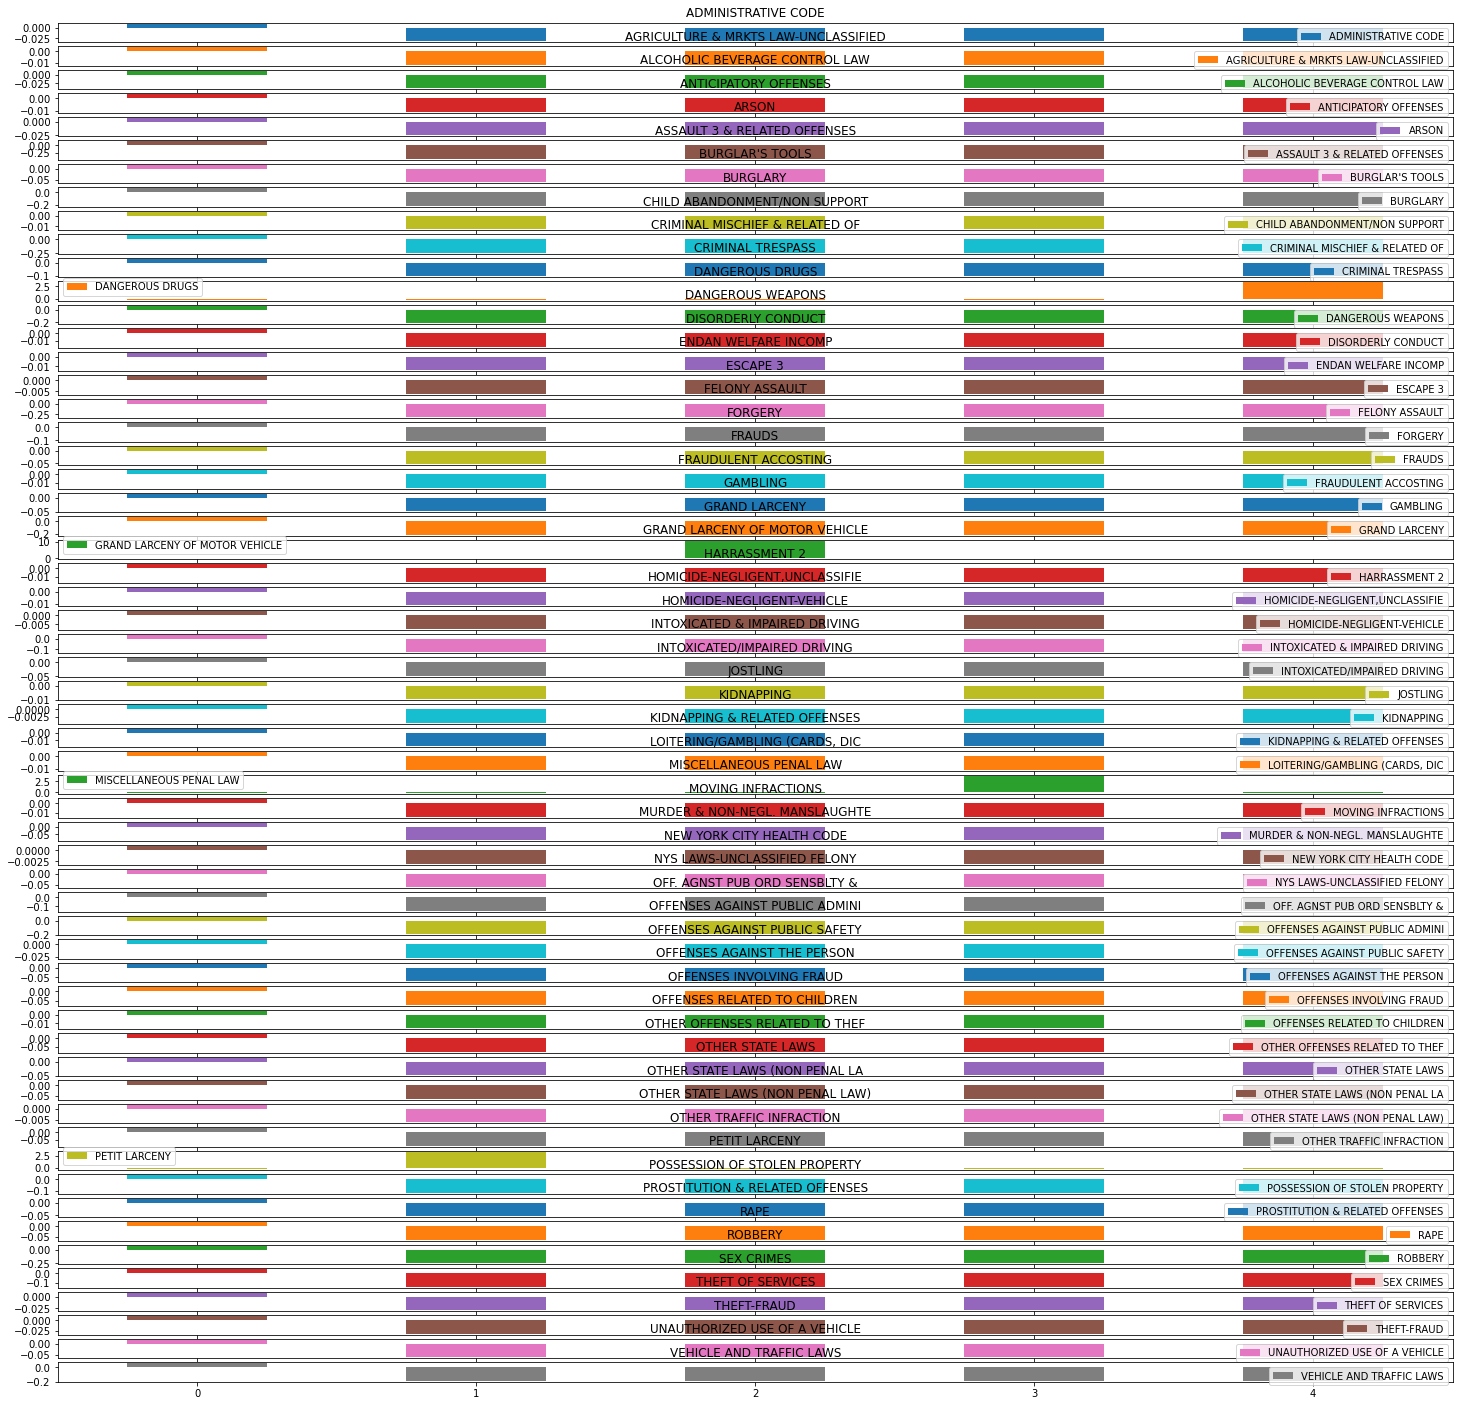

In [27]:
grupos.plot.bar(subplots = True,
              figsize = (25,25),
#               sharex=False,
               rot = 0)
plt.show()

In [38]:
grupo = 0
filtro = modelo.labels_ == grupo
dados_delitos[filtro].sample(15)

,data_da_ocorrencia,descricao_da_ofensa,nivel_da_ofensa,bairro,idade_do_infrator,sexo_do_infrator,raca_do_infrator,latitude,longitude,dia,...,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,VEHICLE AND TRAFFIC LAWS
49957,132,GRAND LARCENY,1,3,45-64,1,5,18279,13675,11,...,0,0,0,0,0,0,0,0,0,0
9558,249,DANGEROUS WEAPONS,1,1,25-44,1,2,9393,5630,5,...,0,0,0,0,0,0,0,0,0,0
21981,174,BURGLARY,1,2,25-44,1,3,23782,10864,22,...,0,0,0,0,0,0,0,0,0,0
31896,232,FELONY ASSAULT,1,2,25-44,1,6,13572,5741,19,...,0,0,0,0,0,0,0,0,0,0
101177,1,ASSAULT 3 & RELATED OFFENSES,0,3,25-44,0,2,12400,24011,1,...,0,0,0,0,0,0,0,0,0,0
5723,268,DANGEROUS WEAPONS,1,3,25-44,0,2,7160,25096,24,...,0,0,0,0,0,0,0,0,0,0
68685,62,VEHICLE AND TRAFFIC LAWS,0,3,25-44,1,4,17098,18912,2,...,0,0,0,0,0,0,0,0,0,1
494,259,ROBBERY,1,1,<18,1,6,8045,6820,15,...,0,0,0,0,1,0,0,0,0,0
26766,203,BURGLARY,1,0,25-44,1,3,21195,19391,21,...,0,0,0,0,0,0,0,0,0,0
77963,73,GRAND LARCENY,1,1,18-24,1,2,7332,13982,13,...,0,0,0,0,0,0,0,0,0,0


- Utilizando um algoritmo pra reduzir o número de dimensões e facilitar a visualização.

In [39]:
from sklearn.manifold import TSNE

In [40]:
tsne = TSNE()

In [ ]:
visualizacao =  tsne.fit_transform(delitos_escalados)
visualizacao

In [ ]:
sns.set(rc={'figure.figsize':(13,10)})

sns.scatterplot(x = visualizacao[:, 0],
               y = visualizacao[:, 1],
               hue =modelo.labels_,
               palette = sns.color_palette('Set1',5))

In [ ]:
# Criando uma função para calcular o erro de acordo com o número de clusters.

def kmeans(numero_de_clusters, delitos):
    modelo = KMeans(n_clusters = numero_de_clusters)
    modelo.fit(delitos)
    return [numero_de_clusters, modelo.inertia_]

In [ ]:
kmeans(15,delitos_escalados)

In [ ]:
resultado = [kmeans(numero_de_grupos, delitos_escalados) for numero_de_grupos in range(1,51 )]

In [ ]:
resultado = pd.DataFrame( resultado,
            columns=['grupos','inertia'])

In [ ]:
resultado.inertia.plot(xticks=resultado.grupos)

Separando as variaveis em X e Y

In [ ]:
X = select_ny.drop('sexo_do_infrator',axis=1).values
Y = select_ny['sexo_do_infrator'].values


Separando em amostras de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_treino,X_teste,Y_treino,Y_teste = train_test_split(X,Y,test_size=0.25,random_state=0)

Aplicando o modelo da arvore de decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

In [ ]:
dte = DecisionTreeClassifier()

In [ ]:
dte.get_params

Ajustando o modelo

In [ ]:
dte.fit(X_treino,Y_treino)

Determinando acurácia na amostra de treino

In [ ]:
score_treino = dte.score(X_treino,Y_treino)

In [ ]:
score_treino

Realizando previsão na amostra de teste

In [ ]:
Y_previsto = dte.predict(X_teste)

In [ ]:
score_teste = dte.score(X_teste,Y_teste)

In [ ]:
score_teste

Gerando matriz de confusão para comparar os resultados

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm=confusion_matrix(Y_teste,Y_previsto)

In [ ]:
sns.heatmap(cm, annot=True , fmt='g')

Alem do score na amostra de teste não estar adequado, devemos notar que muitos casos negativos foram classificados como positivo. Isto pode ser corrigido, ajustando melhor os parâmetros do modelo com GridSearch por exeplo, ou balanceando a amostra

Criando modelo do GridSearchCV

In [ ]:
# critérios para medir a qualidade da divisão dos dados
criterion=['gini','entropy']
max_depth = np.arange(2,10)
max_features= np.arange(2,10)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parametros = {'criterion' : criterion, 'max_depth' : max_depth, 'max_features' : max_features}

In [ ]:
melhor_modelo = GridSearchCV(dte, parametros, n_jobs=-1, cv=5, refit=True, scoring='accuracy')

In [ ]:
melhor_modelo.fit(X_treino, Y_treino)

In [ ]:
modelo_final = melhor_modelo.best_estimator_

In [ ]:
modelo_final

In [ ]:
Y_previsto = modelo_final.predict(X_teste)

In [ ]:
cm_nova=confusion_matrix(Y_teste,Y_previsto)

In [ ]:
sns.heatmap(cm_nova, annot=True , fmt='g')

In [ ]:
score_teste = modelo_final.score(X_teste,Y_teste)

In [ ]:
score_teste

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_teste, Y_previsto))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
roc_score = roc_auc_score(Y_teste, Y_previsto)
print("ROC score = {:0.2f}%".format(roc_score*100))

In [ ]:
roc_fpr, roc_tpr, _ = roc_curve(Y_teste, Y_previsto)

In [ ]:
plt.plot(roc_fpr, roc_tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')